***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](5_0_introduction.ipynb)
    * Previous: [5.2 Sampling functions and PSFs](5_2_sampling_functions_and_psfs.ipynb) 
    * Next: [5.4 The Dirty Image and Visibility Weights](5_4_imaging_weights.ipynb)

***

Import standard modules:

In [87]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Import section specific modules:

In [88]:
from IPython.display import Image

## 5.3 Gridding and Degridding for using the FFT <a id='imaging:sec:gridding'></a>

In the previous section several sampling functions were presented. There the sampling functions were already neatly discretized into images, where each image was a grid of pixels (all with the same size). Fourier inverting such regularly sampled data is done with the Fast Fourier Transform (FFT) algorithm, which operate in roughly $2N^2\log(N)$ steps instead of the normal $N^2M$ with $M\approx N^2$ complex exponentiations and multiplies that would be required in a direct approach, which calculates the intensity of each pixel:

\begin{equation}
 I(l,m) = \sum_{k=0}^{M-1}V_k(u,v)e^{2\pi i (lu+mv)}\text{, }V_k\text{ are the M measurements taken by the telescope}
\end{equation}

From this it should be clear that as the number of baselines or observation time is increased, the FFT approach would be far less time-consuming than the the direct approach. Unfortunately radio interferometers don't generally take measurements at regular intervals, and thus an FFT cannot be used on the observation data directly. Instead the data has to be *resampled* onto a grid with points spaced at regular intervals before taking the FFT. This resampling process and its inverse is the topic of this section.

A second problem related to using the FFT transform approach is that of aliasing. The FFT assumes that the input signal (here the spacial frequency domain) is periodic in nature. The resultant image constructed by resampling and inverse FFT therefore repeats at regular intervals: sources near the top of the image is aliased back into the image at the bottom for instance. This introduces the necessity to filter the image with a filter that only passes signal that falls within the field of view being reconstructed. An example of this aliasing will be given later on.

### 5.3.1 Image Resolution and Pixel Size

When generating an image from visibilities, using either a direct or fast Fourier transform, two parameters need to be defined: the resolution of each pixel and the extent of the image either as a number of pixels or as the size of the field of view (depending on the particular imager). An image will be a 2-d array of size $N_l \times N_m$ and each pixel will have a resolution of $(\Delta \theta_l, \Delta \theta_m)$ if we are making the small angle approximation for the field of view. Recall that the image size is $l = \cos{\theta_l}$, $m = \cos{\theta_m}$, the resolution is $\Delta l = \cos{\Delta \theta_l}$, $\Delta m = \cos{\Delta \theta_m}$ and in the small angle approximation $\Delta l \sim \Delta \theta_l$, $\Delta m \sim \Delta \theta_m$. Though, many imagers can create images which break the small angle approximation the notation is retained. There are a number of techniques for representing a spherical coordinates, via a non-linear transform, on a 2-d plane. In radio interferometry the standard technique is SIN-projection, see [<cite data-cite='Greisen1994'>AIPS Memo 27</cite> &#10548;](ftp://ftp.aoc.nrao.edu/pub/software/aips/TEXT/PUBL/AIPSMEMO27.PS) for a detailed discussion of different coordinate projections.

Given the the resolution $(\Delta \theta_l, \Delta \theta_m)$ and the desired field of view $(\theta_l, \theta_m)$ the number of pixels in the image is

$$N_l = \frac{\theta_l}{\Delta \theta_l}$$

$$N_m = \frac{\theta_m}{\Delta \theta_m}$$

For a given image resolution and size the uv domain resolution/grid size $(\Delta u, \Delta v)$ is

$$\Delta u = \frac{1}{N_l \Delta \theta_l}$$

$$\Delta v = \frac{1}{N_m \Delta \theta_m}$$

And the number of pixels is unchanged $N_u = N_l$, $N_v = N_m$.

An important note about the number of pixels: try to use a value of which is a power of 2, i.e. $N_l = 2^j$, $N_m = 2^k$. This is because of how FFT's are implemented, the optimal run-time efficiency of an FFT is with input lenghts which are powers of 2 and are least efficient when the input length is a prime number. For example, the time required to generate a 256 by 256 pixel image will be less than a 251 by 251 pixel image even though the resulting image will have more pixels because $256 = 2^8$.

### 5.3.2 The UV plane

To start off the discussion on the resampling and image synthesis process let's consider a simulated JVLA observation. The JVLA has 27 reconfigurable antennae. We will use the compact D configuration as shown below:

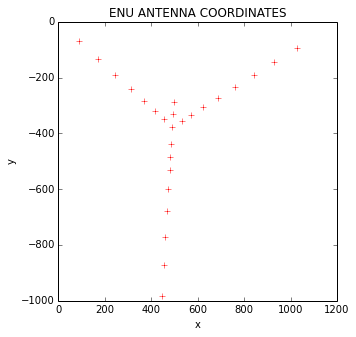

In [89]:
#*************************************************************************************
#JVLA D-CONFIGURATION ANTENNA COORDINATES
#*************************************************************************************

NO_ANTENNA = 27
NO_BASELINES = NO_ANTENNA * (NO_ANTENNA - 1) / 2 + NO_ANTENNA
CENTRE_CHANNEL = 1e9 / 299792458 #Wavelength of 1 GHz
#Antenna positions (from Measurement Set "ANTENNA" table)
#Here we assumed these are in Earth Centred Earth Fixed coordinates, see:
#https://en.wikipedia.org/wiki/ECEF
#http://casa.nrao.edu/Memos/229.html#SECTION00063000000000000000
ANTENNA_POSITIONS = np.array([[-1601710.017000 , -5042006.925200 , 3554602.355600],
                              [-1601150.060300 , -5042000.619800 , 3554860.729400],
                              [-1600715.950800 , -5042273.187000 , 3554668.184500],
                              [-1601189.030140 , -5042000.493300 , 3554843.425700],
                              [-1601614.091000 , -5042001.652900 , 3554652.509300],
                              [-1601162.591000 , -5041828.999000 , 3555095.896400],
                              [-1601014.462000 , -5042086.252000 , 3554800.799800],
                              [-1601185.634945 , -5041978.156586 , 3554876.424700],
                              [-1600951.588000 , -5042125.911000 , 3554773.012300],
                              [-1601177.376760 , -5041925.073200 , 3554954.584100],
                              [-1601068.790300 , -5042051.910200 , 3554824.835300],
                              [-1600801.926000 , -5042219.366500 , 3554706.448200],
                              [-1601155.635800 , -5041783.843800 , 3555162.374100],
                              [-1601447.198000 , -5041992.502500 , 3554739.687600],
                              [-1601225.255200 , -5041980.383590 , 3554855.675000],
                              [-1601526.387300 , -5041996.840100 , 3554698.327400],
                              [-1601139.485100 , -5041679.036800 , 3555316.533200],
                              [-1601315.893000 , -5041985.320170 , 3554808.304600],
                              [-1601168.786100 , -5041869.054000 , 3555036.936000],
                              [-1601192.467800 , -5042022.856800 , 3554810.438800],
                              [-1601173.979400 , -5041902.657700 , 3554987.517500],
                              [-1600880.571400 , -5042170.388000 , 3554741.457400],
                              [-1601377.009500 , -5041988.665500 , 3554776.393400],
                              [-1601180.861480 , -5041947.453400 , 3554921.628700],
                              [-1601265.153600 , -5041982.533050 , 3554834.858400],
                              [-1601114.365500 , -5042023.151800 , 3554844.944000],
                              [-1601147.940400 , -5041733.837000 , 3555235.956000]]);
ARRAY_LATITUDE = 34 + 4 / 60.0 + 43.497 / 3600.0 #Equator->North
ARRAY_LONGITUDE = -(107 + 37 / 60.0 + 03.819 / 3600.0) #Greenwitch->East, prime -> local meridian
REF_ANTENNA = 0
#Conversion from ECEF -> ENU:
#http://www.navipedia.net/index.php/Transformations_between_ECEF_and_ENU_coordinates
slambda = np.sin(np.deg2rad(ARRAY_LONGITUDE))
clambda = np.cos(np.deg2rad(ARRAY_LONGITUDE))
sphi = np.sin(ARRAY_LONGITUDE)
cphi = np.cos(ARRAY_LATITUDE)
ecef_to_enu = [[-slambda,clambda,0],
               [-clambda*sphi,-slambda*sphi,cphi],
               [clambda*cphi,slambda*cphi,sphi]]
enu = np.empty(ANTENNA_POSITIONS.shape)
for a in range(0,NO_ANTENNA):
    enu[a,:] = np.dot(ecef_to_enu,ANTENNA_POSITIONS[a,:])
enu -= enu[REF_ANTENNA]
plt.figure(figsize=(5, 5))
plt.title("ENU ANTENNA COORDINATES")
plt.plot(enu[:,0],enu[:,1],"r+")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

*Figure: Here the positions of the 27 antennae of the JVLA are shown (compact D-configuration)*

As discussed in the previous section in order to accurately reconstruct an image it is necessary to measure a significant portion of the spacial frequency domain. Luckily good coverage on the u,v plane (plane on which the measurements are taken) don't require physically moving the antennae while observing. The Fourier relationship between the sky and the measurements taken by an interferometer depends on the orientation of the baseline vectors between antennae pairs relative to the sky, and these changes as the Earth rotates. As the earth rotates more samples are taken and the tracks swept out by each antenna pair increases in length. As the u,v coordinates are scaled by wavelength the individual tracks can be broadened by integrating many consequtive channels together. Both factors contribute to the accuracy of the reconstruction. The following plots show how the u,v coverage (swept out by pairs of antennae) depend on declination angle, as well as the observation length:

In [90]:
'''
Code snippid to generate simple u,v tracks based on integration length, observation time and ra,dec observation angles
'''
def sim_uv(ref_ra, ref_dec, 
           observation_length_in_hrs, 
           integration_length, 
           plot_on=False):
    
    reference_dec_rad = np.deg2rad(ref_dec)
    integration_length_in_deg = integration_length / 24.0 * 360.0
    no_timestamps = int(observation_length_in_hrs / integration_length)
    row_count = no_timestamps * NO_BASELINES

    l = NO_ANTENNA
    k = NO_ANTENNA
    uvw = np.empty([row_count,3])
    
    for r in range(0,row_count):
        timestamp = r / (NO_BASELINES)
        baseline_index = r % (NO_BASELINES)
        increment_antenna_1_coord = (baseline_index / k)
        
        # calculate antenna 1 and antenna 2 ids based on baseline index using some fancy
        # footwork ;). This indexing scheme will enumerate all unique baselines per
        # timestamp.
        
        l -= (1) * increment_antenna_1_coord
        k += (l) * increment_antenna_1_coord
        antenna_1 = NO_ANTENNA-l
        antenna_2 = NO_ANTENNA + (baseline_index-k)
        new_timestamp = ((baseline_index+1) / NO_BASELINES)
        k -= (NO_BASELINES-NO_ANTENNA) * new_timestamp
        l += (NO_ANTENNA-1) * new_timestamp
        #conversion to local altitude elevation angles:
        #be,bn,bu = ANTENNA_POSITIONS[antenna_1] - ANTENNA_POSITIONS[antenna_2]
        be,bn,bu = enu[antenna_1] - enu[antenna_2]
        mag_b = np.sqrt(be**2 + bn**2 + bu**2)
        epsilon = 0.000000000001
        A = np.arctan(be/(bn + epsilon))
        E = np.arcsin(bu/(mag_b + epsilon))
        #conversion to equitorial coordinates:
        sA = np.sin(A)
        cA = np.cos(A)
        sE = np.sin(E)
        cE = np.cos(E)
        Lx = (cphi*sE-sphi*cE*cA)*mag_b
        Ly = (cE*sA)*mag_b
        Lz = (sphi*sE+cphi*cE*cA)*mag_b
        #conversion to uvw, where w points to the phase reference centre
        rotation_in_radians = np.deg2rad(timestamp*integration_length_in_deg + ref_ra)
        sin_ra = np.sin(rotation_in_radians)
        cos_ra = np.cos(rotation_in_radians)
        sin_dec = np.sin(reference_dec_rad)
        cos_dec = np.cos(reference_dec_rad)
        u = -sin_ra*Lx + cos_ra*Ly
        v = -sin_dec*cos_ra*Lx - sin_dec*sin_ra*Ly + cos_dec*Lz
        w = cos_dec*cos_ra*Lx + cos_dec*sin_ra*Ly + sin_dec*Lz
        uvw[r] = [u,v,w]
        
    if plot_on:
        hrs = int(observation_length_in_hrs)
        mins = int(observation_length_in_hrs * 60 - hrs*60)
        plt.figure(figsize=(5,5))
        plt.title("UV COVERAGE (%dh:%dm @ RA=%f, DEC=%f)" % (hrs,mins,ref_ra,ref_dec))
        plt.plot(uvw[:,0],uvw[:,1],"r.",label="Baselines")
        plt.plot(-uvw[:,0],-uvw[:,1],"b.",label="Conjugate Baselines")
        plt.xlabel("u ($cycles\cdot rad^{-1}\cdot m^{-1}$)")
        plt.ylabel("v ($cycles\cdot rad^{-1}\cdot m^{-1}$)")
        plt.legend(bbox_to_anchor=(1.75, 1.0))
        plt.show()
    return uvw

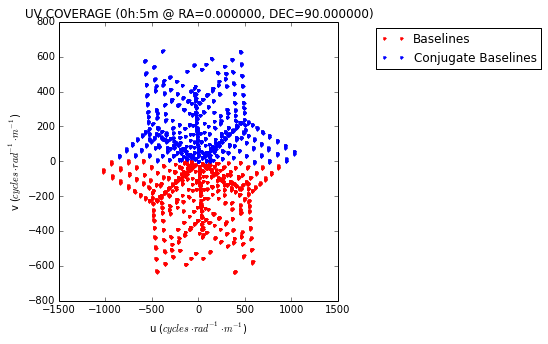

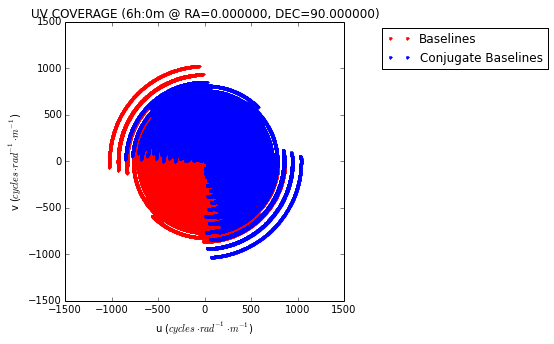

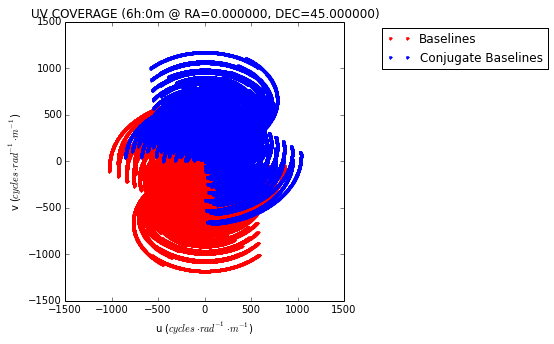

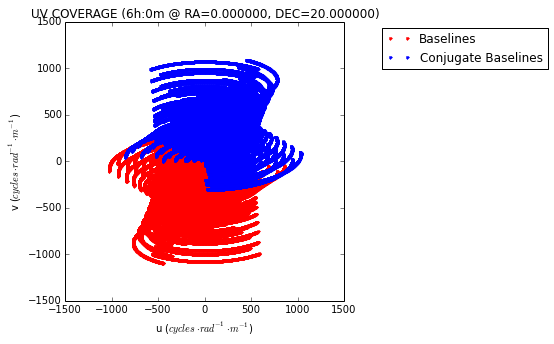

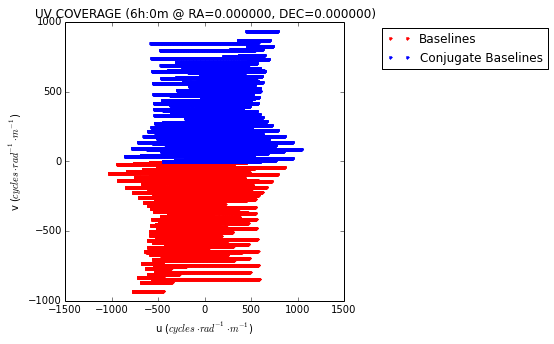

In [91]:
uv_5min = sim_uv(0.0,90.0,5/60.0,60/3600.0,True)
uv_6hrs_90_dec = sim_uv(0.0,90.0,6,60/3600.0,True)
uv_6hrs_45_dec = sim_uv(0.0,45.0,6,60/3600.0,True)
uv_6hrs_20_dec = sim_uv(0.0,20.0,6,60/3600.0,True)
uv_6hrs_0_dec = sim_uv(0.0,0.0,6,60/3600.0,True)

*Figure: UV coverage at various declinations. The projection of the baselines onto the UV plane at $90^\circ$ are concentric circles. As the observation declination decreases the projections become straight lines. Here the baselines and their conjugates are plotted. An interferometer measures both the visibility and its complex conjugate simultaniously (baseline and its negative). The conjugate baselines are redundant measurements and can be discarded.*

However, as is evident these samples do not fall at regularly spaced positions. The goal of *gridding* is to "interpolate" these samples onto regularly spaced grid positions. As you will see later some u,v space image deconvolution algorithms such as the Cotton-Schwab major-minor cycle algorithm requires that sources in image space are reconverted back into the non-regular measurement space. Here an accurate *degridding* operation is required to "interpolate" regularly sampled visibilities back onto the u,v tracks shown above.

### 5.3.3 Gridding and Degridding

As you may suspect there are many ways to interpolate data to and from regular coordinates. The most widely-used technique used in radio imaging programs, such as lwimager, is known as "convolutional-resampling". In this technique each visibility is weighted and smeared out onto grid points that lie within a small distance from the original coordinate.

The value at each grid point is a weighted accumulation of all the nearby visibilties. In one dimension this can be stated as:
\begin{equation}
 (\forall a \in \mathbb{Z}) f(a\Delta{x}) = \sum_{k\in Q\subset\mathbb{R}}f(k)C(a\Delta{x}-k)
\end{equation}

The weighting function, $C$ can be any of the miriad of functions proposed in the literature. These include linear, Lagrange, sinc (including one of the many windowing functions), Gaussian, modified B-spline, etc. 

You may have noticed that the interpolating function above is remarkably close to that of a discrete convolution. If the resampling was done on data that was regularly sampled and the convolution function evaluated at these regular discrete steps then the function would just the ordinary discrete convolution. However, the function as it stands is not quite a convolution, neither is it interpolation by the strictest definition of the word. Gridding and degridding should be thought of as *non-discrete integral convolution approximations*, but we will use the regular convolution notation for it in our discussion.

It is useful to think of these non-discrete convolution operations in terms of the ordinary up- and downsampling operations. In gridding, as with traditional upsampling the space in-between samples are filled with zero values. The only difference is that with gridding the original measurements are not regularly spaced, as would be the case with upsampling. Just as with ordinary upsampling it is then necessary to assign values to these new zero values in-between the measured values. With gridding the values are smeared out over the grid points within a some area of support.

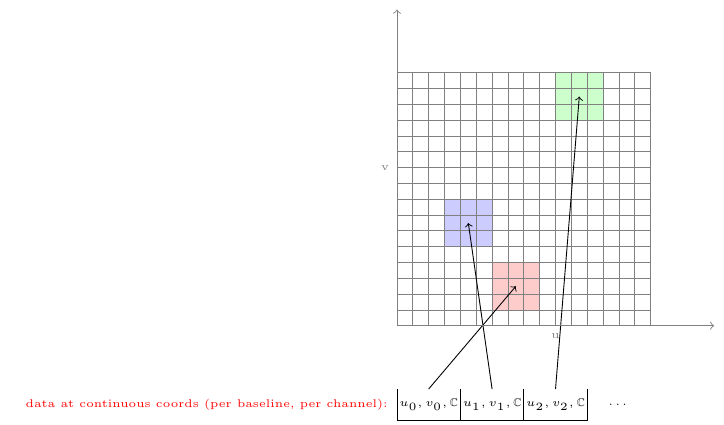

In [92]:
Image(filename="figures/gridding_illustration.png")

*Figure: Each observed visibility (per channel and baseline) is centered at some precomputed coordinate
in continuous u,v space and is “convolved” with some function $C(u,v)$, which extends only to finite “full support”
region as illustrated. The result is binned in a regularly spaced grid when gridding or gathered from this grid when degridding. It should be clear that this is not the standard convolution operator or interpolation. After all the observed visibilities have been gridded an Inverse Fast Fourier Transform is performed and a correcting function is applied to construct an image. The reverse operations are done when simulating a set of visibility measurements from a model sky.*

With this understanding in hand we can define gridding and degridding more rigorously:
\begin{equation}
 \begin{split}
     V_\text{gridded}[u,v]&=[(\mathscr{V}(u,v)S(u,v))\circ C(u,v)]III[u,v]\\
     V_\text{degridded}(u,v)&=[V_\text{gridded}[u,v]\circ C(u,v)]S(u,v)\\
 \end{split}
\end{equation}

In gridding the sampled visibilities are convolved with a convolution function then discretized onto regular points by the shah (bed-of-nails) function. In degridding the opposite is done: the regularly sampled discerete values are convolved and sampled along the sampling tracks in the u,v plane.

The convolution function, $C$, smears (gridding) and gathers (degridding) the visibilities over / from some area of support before discretizing the visibilities to new coordinates. Ideally this function would be computed during the gridding and degridding operations, however, considering that the processing costs of gridding and degridding both scale as $MC_\text{sup}^2$ these functions can be too computationally expensive to compute for every visibility and is normally pretabulated for a given support size. Additionally it is important to sample this function much more densely than the spacings between grid cells; interferometers take measurements in the spatial frequency domain and any large snapping / rounding operation on the coordinates of the samples will result in a decorrelation in the structural information about the image. The figure below illustrates how values are picked from the oversampled filter.

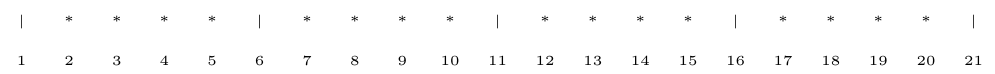

In [93]:
Image(filename="figures/oversampled_filter_illustration.png")

*Figure: A ficticious filter is shown here. Here the padded and oversampled C[x] filter is illustrated for a 3-cell full-support region (half support of 1 to both sides of the centre value), padded with one value on both sides. The filter is 5x oversampled, as indicated by the spaces between the asterisks. The bars represent the cell-spacing ($\Delta{u}$ for instance) used for the grid. If the measured uv coordinate falls exactly on the nearest grid cell then values 6,11 and 16 are selected as interpolation coefficients. If $\text{round}(\text{fraction}(u, v)m_\text{oversample factor})$ = 2 for instance then 8, 13 and 18 are selected for the 3 grid points being “convolved”. In other words: a denser bed of nails is placed over the bed of nails of the grid and the closest set of coefficients for the convolution are selected.*

In addition to accuracy the alias-reduction properties of the convolution filter, $C$ being used is essential to the FFT approach. By the convolution relation the reconstructed image of the radio sky can be stated as follows:
\begin{equation}
I_\text{dirty}[l,m] = ([I(l,m)\circ\text{PSF}(l,m)]c(l,m))\circ\mathscr{F}\{III(u,v)\}(l,m)
\end{equation}

Convolution with the fourier transform of the shah function (a series of periodic functions in the image domain) replicates the field of view at a period of $M\text{cell}_l$ and $N\text{cell}_m$ for an $M\times N$ pixel image, and it is this undesirable replication that must be stopped. To that end one would hope that the fourier transform of the convolution filter, $c(l,m)$, maximizes the following ratio:
\begin{equation}
\frac{\int_\text{FOV}|c(l,m)|^2dS}{\int_{-\infty}^\infty|c(l,m)|^2dS}
\end{equation}

Simply stated it is desirable that the function $c$ is only non-zero over a small central region, the field of view.

Both the remarks about accuracy and fourier response precludes using a nearest neighbour approach to interpolating points to and from regular coordinates. This technique (also known as *cell-summing*) simply accumulates the neighbouring points that fall within a rectangular region around the new coordinate, without considering the distance those points are from the new coordinate. The fourier-response to this box function is an infinite sinc function, which ripples out slowly towards infinity and doesn't stop much of the aliasing energy. Convolutional gridding/degridding is therefore a more attractive approach, because the distance between the grid point and the measured uv point is taken into account when selecting a set of convolution weights.

The observation about the fourier response of the box function leads us to a partial solution for the aliasing problem, in that the fourier reponse to convolving with an *infinite* sinc will yield a box response. Unfortunately this is not computationally feasible and instead the best option is to convolve with a windowed sinc function, or some other function that has a similar centre-heavy fourier response and preferably tapers off reasonably quickly. The images below illustrates the significant improvement using a truncated sinc function compared to nearest-neighbour interpolation.

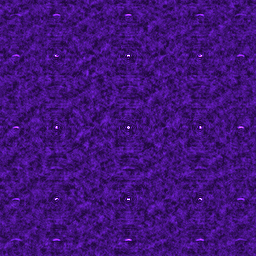

In [94]:
Image(filename="figures/NN_interpolation_aliasing.png")

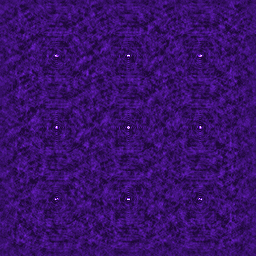

In [95]:
Image(filename="figures/AA_kernel_alias_reduction.png")

*Figure: Above two synthesized images are shown. The first using cell-summing (nearest neighbour) interpolation and the second using convolutional resampling with a simple truncated sinc function. In the first the sources of this grid sky pattern that fall slightly outside the field of view are aliased back into the field of view. In the second the aliasing energy is limited by the box response of the sinc function.*

Below the magnitude of the sidelobes of the fourier responses are plotted. The response of the box function is significantly higher than that of truncated and windowed sinc functions.

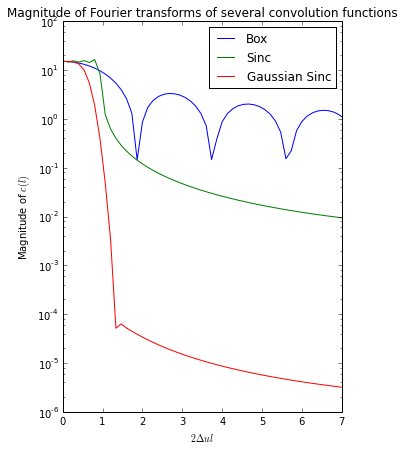

In [96]:
half_sup = 6
oversample = 15
full_sup_wo_padding = (half_sup * 2 + 1)
full_sup = full_sup_wo_padding + 2 #+ padding
no_taps = full_sup + (full_sup - 1) * (oversample - 1)
taps = np.arange(-no_taps//2,no_taps//2 + 1)/float(oversample)

#unit box
box = np.where((taps >= -0.5) & (taps <= 0.5),
               np.ones([len(taps)]),np.zeros([len(taps)]))
fft_box=np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(box))))
#truncated (boxed) sinc
sinc = np.sinc(taps)
fft_sinc=np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinc))))
#gaussian sinc
alpha_1=1.55
alpha_2=2.52
gsinc = np.sin(np.pi/alpha_1*(taps+0.00000000001))/(np.pi*(taps+0.00000000001))*np.exp(-(taps/alpha_2)**2)
fft_gsinc=np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(gsinc))))
#plot it up
plt.figure(figsize=(5, 7), dpi=80)
l = np.arange(-(no_taps)//2,(no_taps)//2+1) * (1.0/oversample)
a, = plt.plot(2*l,fft_box)
b, = plt.plot(2*l,fft_sinc)
c, = plt.plot(2*l,fft_gsinc)
ax = plt.gca()
ax.set_xlim(0,no_taps//2 * (1.0/oversample))
ax.set_yscale("log", nonposy='clip')
plt.legend([a,b,c],["Box","Sinc","Gaussian Sinc"])
plt.xlabel("$2\Delta{u}l$")
plt.ylabel("Magnitude of $c(l)$")
plt.title("Magnitude of Fourier transforms of several convolution functions")
plt.show()

*Figure: The magnitudes of the fourier transforms of various functions. It is desirable that most of the energy of these functions fall within some central region and that the response drops off sharply at the edge of this central region*

After fourier transformation the effects of the convolution function on the image can be mitigated by point-wise dividing the image through by the fourier transform of the convolution function, $c(l,m)$. This has the effect of flattening the response of the passband, by removing the tapering towards the edges of the image, but raises the amplitude of any aliased sources at the edge of the image.

In practice the proloid spheroidal functions are used in imaging programs such as lwimager, but the definition of these functions are beyond the scope of the introductory discussion here and the reader is referred to the work of Donald Rhodes, [<cite data-cite='rhodes1970spheroidal'>On the Spheroidal Functions</cite> &#10548;](http://cdm16009.contentdm.oclc.org/cdm/compoundobject/collection/p13011coll6/id/61576/rec/50) for a detailed discussion of their definition and proof of their aliasing reduction properties.

It is also worth noting that the convolution functions used in gridding and degridding need not be the same function. In degridding the focus is solidly on the accuracy of the predicted visibility. Here it can be advantageous to minimize the difference between a direct transformation approach and a Fast Fourier Transform approach with degridding, see for instance the discussion by Sze Tan, [<cite data-cite='tan1986aperture'>Aperture-synthesis mapping and parameter estimation</cite> &#10548;](http://ethos.bl.uk/OrderDetails.do?uin=uk.bl.ethos.384529) for further detail. 

### 5.3.4 Example simulator and imager

We conclude this section with some sample code to illustrate prediction and imaging using resampling and the FFT. To start off let's set up a model sky with 50 random sources with a maximum brightness of 5Jy. Then we simulate the measurement space by taking the fourier transform of this model sky:

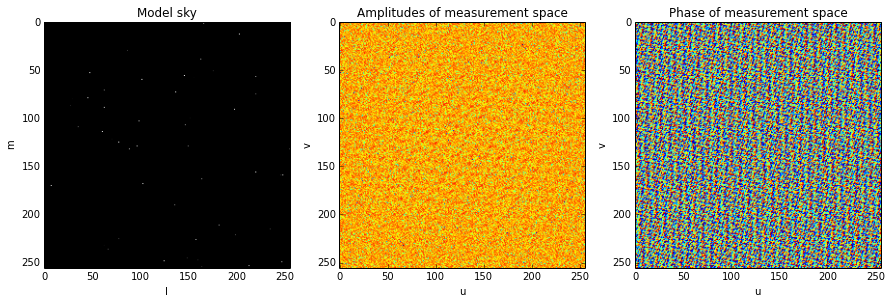

In [97]:
model_sky=np.zeros([256,256])
for i in range(50):
    model_sky[np.random.rand()*255,np.random.rand()*255] = np.random.rand()*5.0 
model_regular = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(model_sky))) #numpy's FFT doesn't need normalization
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title("Model sky")
plt.imshow(model_sky,cmap="gray")
plt.xlabel("l")
plt.ylabel("m")
plt.subplot(132)
plt.title("Amplitudes of measurement space")
plt.imshow(10*np.log10(np.abs(model_regular+0.000000000001)))
plt.xlabel("u")
plt.ylabel("v")
plt.subplot(133)
plt.title("Phase of measurement space")
plt.imshow(np.angle(model_regular))
plt.xlabel("u")
plt.ylabel("v")
plt.show()

*Figure: The simulated model sky (l,m space) and its fourier transform in the measurement space (u,v space)*

Next we set up a sampling pattern and scale the u,v tracks to ensure that they all fall within the u,v grid:

Maximum u,v: (1029.866900,750.465562)
Nyquest cell size (radians) in image space (8.045835,5.863012)
234.39854203 185.984195031


<matplotlib.colorbar.Colorbar instance at 0x7f17bb2b9c20>

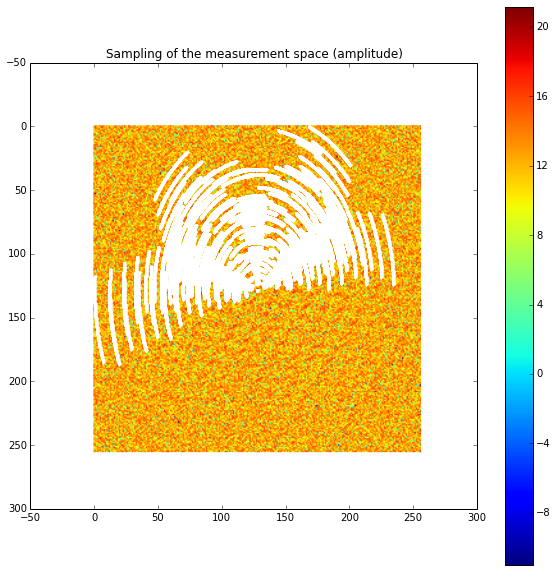

In [98]:
#Set up interferometer sampling pattern
uvw = sim_uv(0.0,90.0,1.5,60/3600.0)
#Then scale the u,v coordinates such that the uv coverage falls entirely on the uv grid
max_u = np.max(np.abs(uvw[:,0]))
max_v = np.max(np.abs(uvw[:,1]))
print "Maximum u,v: (%f,%f)" % (max_u,max_v)
#N * cell_size_in_rads = 2 * max_uv
#therefore cell_size_in_rads = 2 * max_uv / N
Nx = model_sky.shape[0]
Ny = model_sky.shape[1]
cell_size_u = 2 * max_u / (Nx)
cell_size_v =  2 * max_v / (Ny)
print "Nyquest cell size (radians) in image space (%f,%f)" % (cell_size_u,cell_size_v)
scaled_uv = np.copy(uvw[:,0:2])
scaled_uv[:,0] /= cell_size_u
scaled_uv[:,1] /= cell_size_v
scaled_uv[:,0] += Nx/2
scaled_uv[:,1] += Ny/2
print np.max(scaled_uv[:,0]),np.max(scaled_uv[:,1])
plt.figure(figsize=(10, 10))
plt.title("Sampling of the measurement space (amplitude)")
plt.imshow(10*np.log10(0.00000000001+np.abs(model_regular)))
plt.plot(scaled_uv[:,0],scaled_uv[:,1],"w.",label="Baselines")
plt.colorbar()

*Figure: UV tracks scaled onto the regularly sampled measurement space*

To complete the prediction (also known as the "forward" step) the measurements are resampled onto the u,v tracks of the interferometer using the *degridding* algorithm discussed above. Measurements are gathered and weighted from the vacinity of each of the points along the sampling track in order to "predict" a value at the u,v coordinate.

In [99]:
#*************************************************************************************
#Degridding algorithm
#*************************************************************************************
vis = np.zeros([uvw.shape[0]],dtype=np.complex)
for r in range(0,uvw.shape[0]):
    disc_u = int(round(scaled_uv[r,0]))
    disc_v = int(round(scaled_uv[r,1]))
    frac_u_offset = (1 - scaled_uv[r,0] + disc_u) * oversample
    frac_v_offset = (1 - scaled_uv[r,1] + disc_v) * oversample
    if (disc_v + full_sup_wo_padding  >= Ny or disc_u + full_sup_wo_padding >= Nx or
        disc_v < 0 or disc_u < 0): 
        continue
    interpolated_value = 0.0 + 0.0j
    for conv_v in range(0,full_sup_wo_padding):
         v_tap = sinc[conv_v * oversample + frac_v_offset]  
         for conv_u in range(0,full_sup_wo_padding):
            u_tap = sinc[conv_u * oversample + frac_u_offset]
            conv_weight = v_tap * u_tap
            interpolated_value += model_regular[disc_u - half_sup + conv_u, disc_v - half_sup + conv_v] * conv_weight
    vis[r] = interpolated_value

Next comes a simplified imaging step using the FFT and gridding. The visibilities on the irregularly-spaced u,v tracks are resampled onto regular coordinates. This is done by weighting and smeering each measured visibility out onto the regular coordinates in the vacinity of its u,v coordinate. After resampling the inverse FFT is used to transform the measurements in the spacial frequency domain to those in the spacial domain, thereby approximately reconstructing the model sky we started with.

In [100]:
#*************************************************************************************
#Gridding algorithm
#*************************************************************************************
measurement_regular = np.zeros([Nx,Ny],dtype=np.complex) #one grid for the resampled visibilities
sampling_regular = np.zeros([Nx,Ny],dtype=np.complex) #one grid for the resampled sampling function
for r in range(0,uvw.shape[0]):
    disc_u = int(round(scaled_uv[r,0]))
    disc_v = int(round(scaled_uv[r,1]))
    frac_u_offset = (1 - scaled_uv[r,0] + disc_u) * oversample
    frac_v_offset = (1 - scaled_uv[r,1] + disc_v) * oversample
    if (disc_v + full_sup_wo_padding  >= Ny or disc_u + full_sup_wo_padding >= Nx or
        disc_v < 0 or disc_u < 0): 
        continue
    for conv_v in range(0,full_sup_wo_padding):
         v_tap = sinc[conv_v * oversample + frac_v_offset]  
         for conv_u in range(0,full_sup_wo_padding):
            u_tap = sinc[conv_u * oversample + frac_u_offset]
            conv_weight = v_tap * u_tap
            measurement_regular[disc_u - half_sup + conv_u, disc_v - half_sup + conv_v] += vis[r] * conv_weight
            sampling_regular[disc_u - half_sup + conv_u, disc_v - half_sup + conv_v] += (1+0.0j) * conv_weight

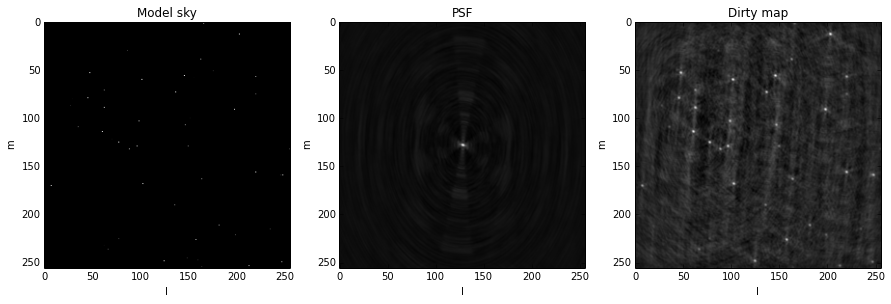

In [101]:
#plot it up :-)
dirty_sky = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(measurement_regular)))
psf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sampling_regular)))
dirty_sky /= np.max(psf) # normalize by the centre value of the PSF
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title("Model sky")
plt.imshow(model_sky,cmap="gray")
plt.xlabel("l")
plt.ylabel("m")
plt.subplot(132)
plt.title("PSF")
plt.imshow(np.abs(psf),cmap="gray")
plt.xlabel("l")
plt.ylabel("m")
plt.subplot(133)
plt.title("Dirty map")
plt.imshow(np.abs(dirty_sky),cmap="gray")
plt.xlabel("l")
plt.ylabel("m")
plt.show()

*Figure: Reconstructed image of the model sky. This "dirty" image is convolved with the the PSF shown in the centre figure. Some of the fainter sources are hardly visible because of the sidelobes introduced by this convolution.*

Of course this reconstruction can only ever be approximate, since the u,v plane is only partially sampled. The brightest sources are still visible, provided the observation time is long enough. Each of the sources are convolved with the PSF shown above in the centre figure; the ring-like structure of the PSF is clearly visible around the bright sources and can, in the worst case, obscure some of the fainter sources in the image. The deconvolution strategies discussed later attepts to remove the psf structure from the images and improves the fidelity of the reconstructed images.

***

* Next: [5.4 The Dirty Image and Visibility Weights](5_4_imaging_weights.ipynb)